In [15]:
!pip install transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing Libraries
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Loading some sklearn packaces for modelling.
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import logging
import itertools
import random
import warnings
import time
import datetime
import pickle

# Plotting Libraries
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Model Libraries
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Conv1D, SpatialDropout1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

# Setting some options for general use.
import os
stopWords = set(stopwords.words('english'))
# plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [16]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"

In [17]:
# Read the data
df = pd.read_csv('training.1600000.processed.noemoticon.csv', 
                 encoding = DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [18]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

df.target = df.target.apply(lambda x: decode_sentiment(x))

# **Process Raw input data**

In [19]:
stemmer = SnowballStemmer('english')

def removeStopwordsAndStem(text, stem=False):
    tokens = []
    for token in text.split():
        if token not in stopWords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:    
                tokens.append(token)
    return " ".join(tokens)


def removeURL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def removeHTML(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def removeSymbols(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

df['text_clean'] = df['text'].apply(lambda x: removeStopwordsAndStem(x, True))
df['text_clean'] = df['text_clean'].apply(lambda x: removeURL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: removeHTML(x))
df['text_clean'] = df['text_clean'].apply(lambda x: removeSymbols(x))

df.head()

,target,ids,date,flag,user,text,text_clean
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww that bummer you shoulda got ...
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant updat facebook text it might cri re...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan i dive mani time ball manag save 50 t...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no behav all im mad here i can...


In [20]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [21]:
# Hyperparameters
max_length = 140
batch_size = 512

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Splitting Test and Train Data

In [22]:
train_df, test = train_test_split(df, test_size=0.01, random_state=42)
x_train, dev = train_test_split(train_df, test_size=0.01, random_state=42)
print(x_train.shape)
print(test.shape)
print(dev.shape)

(1568160, 7)
(16000, 7)
(15840, 7)


In [23]:
train = x_train[:500000]

In [24]:
labels = train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [25]:
encoder = LabelEncoder()
encoder.fit(train.target.tolist())

y_train = encoder.transform(train.target.tolist())
y_test = encoder.transform(test.target.tolist())
y_dev = encoder.transform(dev.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_dev = y_dev.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (500000, 1)
y_test (16000, 1)


In [26]:
train.text_clean

1142189           jassy1015jamz hey heard drop perfect thank
369509                                      i want take sats
660753                hannahtroy hahaha awesmebut one rememb
320150            8 kid might end serious high therapi bills
341822     monikaaabitch lol like mum they said peopl sic...
                                 ...                        
325948     i must say soni came swing like microsoft iam ...
1307706            markal which tweet thati glad perceiv way
296534        yay just iv alway wanted  im sick end sarcasim
924090                             red game sean mayb eric 1
960715                               thankssss ruben rubaaan
Name: text_clean, Length: 500000, dtype: object

In [27]:
dev.text_clean

575957                                   serious i want book
1329368                              three week warning come
1470346        kathgrca and what banana split version hahaha
599695            support act x via davidnotmark support act
1107899                          eatin chines food breakfast
                                 ...                        
1056426                                         addict tweet
1338607    loweryc i make salsa chicken add rice chicken ...
908484                     theraj happi star war 2u2 tbbtfan
655496          oh parent get rid disney channel ppp tonight
1085561                  omar lol im lost goodnight everyone
Name: text_clean, Length: 15840, dtype: object

In [28]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])


train_encoded = bert_encode(train.text_clean)
dev_encoded = bert_encode(dev.text_clean)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, y_dev))
    .shuffle(128)
    .batch(batch_size)
)

# Model

In [29]:
def bert_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]
    x = SpatialDropout1D(0.2)(last_hidden_states)
    x = Conv1D(32, 3, activation='relu')(x)
    x = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(input_word_ids, outputs)
    
    return model

with strategy.scope():
    model = bert_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 140)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             140, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

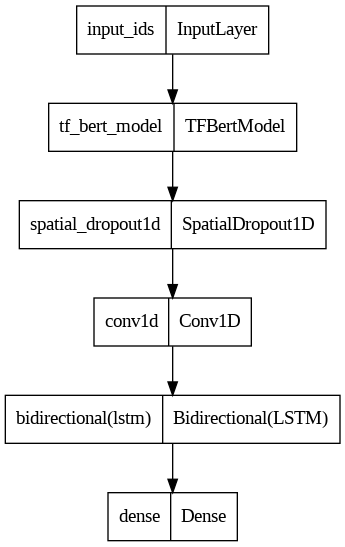

In [30]:
tf.keras.utils.plot_model(model)

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-5, patience=5)]

# Start train
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=3,
    validation_data=dev_dataset,
    verbose=1,
    callbacks = callbacks)

Epoch 1/3


977/977 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.7723

977/977 [==============================] - 705s 621ms/step - loss: 0.4680 - accuracy: 0.7723 - val_loss: 0.4245 - val_accuracy: 0.8037 - lr: 1.0000e-04
Epoch 2/3
977/977 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8240

977/977 [==============================] - 538s 551ms/step - loss: 0.3901 - accuracy: 0.8240 - val_loss: 0.4270 - val_accuracy: 0.8079 - lr: 1.0000e-04
Epoch 3/3
977/977 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.8597

977/977 [==============================] - 544s 557ms/step - loss: 0.3257 - accuracy: 0.8597 - val_loss: 0.5092 - val_accuracy: 0.8001 - lr: 1.0000e-04


In [32]:
model

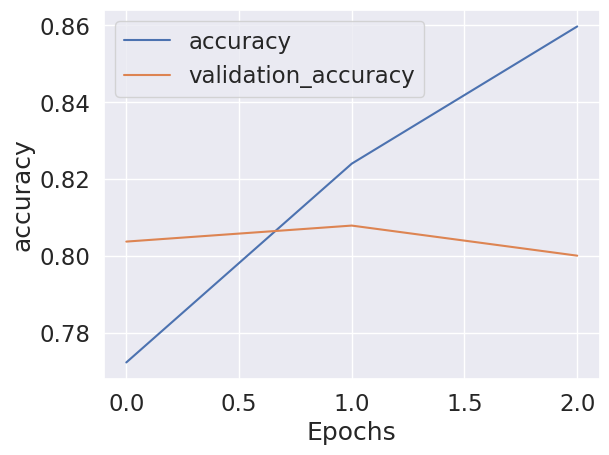

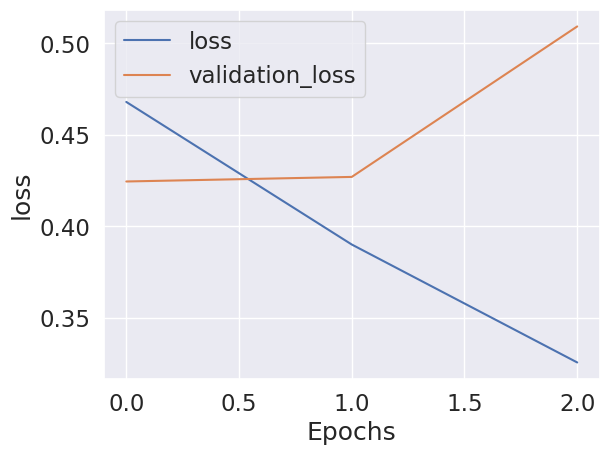

In [33]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel('accuracy')
    plt.legend(['accuracy', 'validation_accuracy'])
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel('loss')
    plt.legend(['loss', 'validation_loss'])
    plt.show()
   
plot_accuracy(history)
plot_loss(history)


In [39]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

def predict(text, include_neutral=False):
    start_at = time.time()
    x_encoded = bert_encode([text])
    score = model.predict([x_encoded])[0]
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  


predict("good morning")


1/1 [==============================] - 11s 11s/step


{'label': 'POSITIVE',
 'score': 0.9885055422782898,
 'elapsed_time': 11.440365314483643}

In [41]:
predict("Just had the best day ever at the beach! Sun, sand, and waves. Can't wait to go back! #summerfun #beachday")

1/1 [==============================] - 1s 884ms/step


{'label': 'POSITIVE',
 'score': 0.9870897531509399,
 'elapsed_time': 1.0636332035064697}

In [42]:
predict("Feeling so frustrated with this never-ending traffic. Why does it always have to be this way? #trafficwoes #ugh")

1/1 [==============================] - 1s 893ms/step


{'label': 'NEGATIVE',
 'score': 0.003583848476409912,
 'elapsed_time': 1.0315337181091309}

In [43]:
predict("Just got my dream job offer! So excited to start this new chapter in my life. #dreamjob #careermove")

1/1 [==============================] - 1s 894ms/step


{'label': 'POSITIVE',
 'score': 0.9832967519760132,
 'elapsed_time': 1.047736644744873}

In [44]:
predict("The film does a good job of balancing this large cast and it’s just a fun superhero movie with a lot of heart.")

1/1 [==============================] - 1s 795ms/step


{'label': 'POSITIVE',
 'score': 0.9945693016052246,
 'elapsed_time': 0.935859203338623}

In [45]:
predict("So disappointed with the customer service at this store. They were rude and unhelpful. #customerservicefail #disappointed")

1/1 [==============================] - 1s 896ms/step


{'label': 'NEGATIVE',
 'score': 0.0036315321922302246,
 'elapsed_time': 1.018143653869629}

In [47]:
pickle.dump(model, open('bert-v1.pkl', 'wb'))